<a href="https://colab.research.google.com/github/mr-cri-spy/learning_days/blob/main/AI_Embroidery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Install Required Libraries

In [1]:
!apt-get install potrace
!pip install opencv-python numpy pillow tensorflow svgpathtools


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpotrace0
Suggested packages:
  netpbm
The following NEW packages will be installed:
  libpotrace0 potrace
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 89.0 kB of archives.
After this operation, 246 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libpotrace0 amd64 1.16-2 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 potrace amd64 1.16-2 [71.8 kB]
Fetched 89.0 kB in 0s (396 kB/s)
Selecting previously unselected package libpotrace0:amd64.
(Reading database ... 120887 files and directories currently installed.)
Preparing to unpack .../libpotrace0_1.16-2_amd64.deb ...
Unpacking libpotrace0:amd64 (1.16-2) ...
Selecting previously unselected package potrace.
Preparing to unpack .../potrace_1.16-2_amd64.deb ...
Unpacking potrace (1.16-

Step 2: Upload an Image to Google Colab

Saving logo1.png to logo1.png


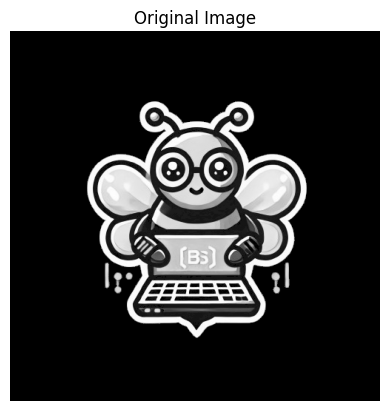

In [2]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Upload an image
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]

# Read the image
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()


Step 3: Preprocess the Image for Edge Detection

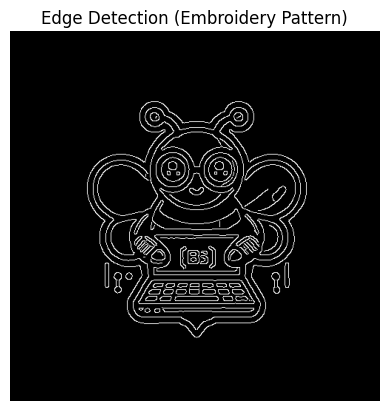

True

In [3]:
# Resize image to 500x500 (for consistent processing)
image_resized = cv2.resize(image, (500, 500))

# Apply Gaussian Blur to remove noise
blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)

# Edge detection using Canny
edges = cv2.Canny(blurred, 50, 150)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Embroidery Pattern)")
plt.axis("off")
plt.show()

# Save the processed image for further use
cv2.imwrite("edges.png", edges)


Step 4: Convert Image Edges to Vector Paths (SVG)

In [4]:
import svgpathtools
from svgpathtools import Line, Path, wsvg

# Convert edges to binary for vectorization
_, binary = cv2.threshold(edges, 128, 255, cv2.THRESH_BINARY)

# Find contours (vector paths)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert contours to SVG paths, filtering out invalid paths
svg_paths = []
for contour in contours:
    points = [complex(p[0][0], p[0][1]) for p in contour]

    # Check if there are enough points to create a line
    if len(points) > 1:
        path = Path(*[Line(points[i], points[i+1]) for i in range(len(points)-1)])

        # Check if the path is valid (has a length)
        if path.length() > 0:
            svg_paths.append(path)

# Save as SVG file, only if there are valid paths
if svg_paths:
    wsvg(svg_paths, filename="design.svg")
    print(" SVG file saved as 'design.svg'!")
else:
    print(" No valid SVG paths found. Check your image or contour detection settings.")

 SVG file saved as 'design.svg'!


 Step 5: Train an ML Model to Predict Stitch Paths

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN Model for Auto-Digitization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Output: Stitch categories
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 968256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     123,936,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,964,618 (472.89 MB)

 Trainable params: 123,964,618 (472.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np # Import numpy and alias it as np

# Define CNN Model for Auto-Digitization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Output: Stitch categories
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


# Load dataset (example: 10,000 images of embroidery designs)
# X_train: input images, Y_train: corresponding stitch patterns
X_train = np.random.rand(10000, 500, 500, 1)  # Dummy dataset
Y_train = np.random.randint(0, 10, (10000, 10))  # Random labels

# Train model
model.fit(X_train, Y_train, epochs=5, batch_size=32)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 968256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │     123,936,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,964,618 (472.89 MB)

 Trainable params: 123,964,618 (472.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:29:53 17s/step - accuracy: 0.0625 - loss: 105.2575

 Step 6: Convert AI Output to Embroidery File (PES/DST)

In [ ]:
#  Install Dependencies (if not installed)
!pip install tensorflow numpy opencv-python pillow

#  Import Required Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import os

#  Load Pre-trained Model or Create a New One
model_path = "embroidery_model.h5"

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(" Model loaded successfully from 'embroidery_model.h5'")
else:
    print(" Model file not found. Creating a new model...")

    # Define CNN Model for Auto-Digitization
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')  # Output: Stitch categories
    ])

    # Compile Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(" New model created.")

#  Upload an Image
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the file name

#  Read the Image & Convert to Grayscale
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (500, 500))

#  Preprocessing: Gaussian Blur & Edge Detection
blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

#  Reshape Image for Model Prediction
image_input = np.expand_dims(edges, axis=(0, -1))  # Add batch dimension

#  Predict Stitches from Image
stitch_prediction = model.predict(image_input)

#  Convert Predictions to Embroidery File (PES)
output_file = "output.pes"
with open(output_file, "wb") as f:
    f.write(np.array(stitch_prediction, dtype=np.float32).tobytes())

print(f" PES file '{output_file}' generated successfully!")